In [1]:
import os
import sys
print("Python version: ", sys.version)
import numpy as np
print("numpy version", np.__version__)
import pandas as pd
import itertools
import random
import datetime
import time
import cv2

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version", matplotlib.__version__)
import matplotlib.patches as patches

import tensorflow as tf
print("tensorflow version", tf.__version__)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


from tqdm import tqdm
tqdm.pandas()

from IPython import display
from __future__ import print_function, division

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

import simulate
import process

from pathlib import Path
Path("./images").mkdir(parents=True, exist_ok=True)

DATA_PATH = "./data/"
MARKER_PATH = "./markers_official/"

Python version:  3.8.10 (default, Mar 15 2022, 12:22:08) 
[GCC 9.4.0]
numpy version 1.23.1
matplotlib version 3.5.2
TF: 2.9.1


In [2]:
def load_data(path, suffix):
    lstDfs = []
    for f in tqdm([f"16h5_{suffix}.pkl", f"36h11_{suffix}.pkl"], desc="Load files"):
        lstDfs.append(pd.read_pickle(f"{path}{f}"))

    df = pd.concat(lstDfs)

    df["Template"] = df.progress_apply(lambda e: simulate.load_tag(e.Size, e.MarkerType, e.Id, e.Angle, MARKER_PATH=MARKER_PATH) /127.5 - 1. , axis=1)

    # create train/test/val split
    if (suffix == "validation"):
        df['Datatype'] = "val"
    else:
        np.random.seed(420)
        indices = list(df.index)
        np.random.shuffle(indices)
        
        df['Datatype'] = ""
        train, test = .7, .3

        train_len = int(np.ceil(len(indices)*train))
        test_len = int(train_len + np.ceil(len(indices)*test))

        train_ids = indices[:train_len] 
        test_ids = indices[train_len:test_len]

        df.loc[train_ids, 'Datatype'] = 'train'
        df.loc[test_ids, 'Datatype'] = 'test'
    
    return df

In [3]:
df = load_data(DATA_PATH, suffix = 'training')
df_val = load_data(DATA_PATH, suffix = 'validation')

100%|██████████| 862412/862412 [03:46<00:00, 3807.79it/s]


In [4]:
simulator = tf.keras.models.load_model("./model_simulator/", compile = False)

2022-07-11 18:11:39.524119: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-11 18:11:40.041560: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 28529 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0


In [5]:
batch_size = 512

In [ ]:
%%time
times = {}
for t in [1,2,4,8]:
    tmp = []
    simulations = []
    for i in tqdm(range(0, len(df_val), batch_size * t)):
        start_time = datetime.datetime.utcnow().timestamp()

        x_val = df_val.iloc[i: i + batch_size * t].Template.values
        x_val = np.expand_dims(np.stack(x_val), axis = 3)
        simulations.append(simulator.predict(x_val, verbose=0,  use_multiprocessing=True, batch_size=batch_size * t))
        tmp.append(datetime.datetime.utcnow().timestamp()-start_time)
    times[t] = tmp

In [8]:
print("Simulator")
print(f"Tested on {len(df_val)} items")
for key, value in times.items():
    v = np.array(value)
    print(f"""Batchsize: {batch_size*key}\t -- #batches: {len(v)} -- {v.mean().round(3)}s on average , {(v.sum()/60).round(3)}s total """)

Simulator
Tested on 862412 items
Batchsize: 512	 -- #batches: 1685 -- 0.287s on average , 8.066s total 
Batchsize: 1024	 -- #batches: 843 -- 0.506s on average , 7.103s total 
Batchsize: 2048	 -- #batches: 422 -- 0.969s on average , 6.817s total 
Batchsize: 4096	 -- #batches: 211 -- 1.868s on average , 6.571s total 


In [6]:
def getStatistics(df):
    
    batch_size = 1024
    simulations = []

    for i in tqdm(range(0, len(df), batch_size)):
        x_val = df.Template.iloc[i : i + batch_size].values
        x_val = np.expand_dims(np.stack(x_val), axis = 3)
        simulations.append(simulator.predict(x_val, verbose=0, use_multiprocessing=True, batch_size=batch_size, workers=10))
    
    df['Simulation'] = list(np.vstack(simulations))
    df.Simulation = (df.Simulation+1)*127.5
    df.Simulation = df.Simulation.apply(lambda x: x.reshape((32, 32)))
    
    df['Diff'] =  df.Simulation - df.Blob
    df['AveragePixelError'] = df.Diff.apply(lambda e: np.mean(np.abs(e)))

    df['DiffMax'] = df.Diff.apply(lambda x: np.abs(x).max())
    
    return df

In [7]:
df = getStatistics(df)
df_val = getStatistics(df_val)

  0%|          | 0/424 [00:00<?, ?it/s]2022-07-11 18:11:42.085222: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-07-11 18:11:42.672792: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
100%|██████████| 843/843 [06:16<00:00,  2.24it/s]


CPU times: user 22.7 s, sys: 3.95 s, total: 26.7 s
Wall time: 26.7 s


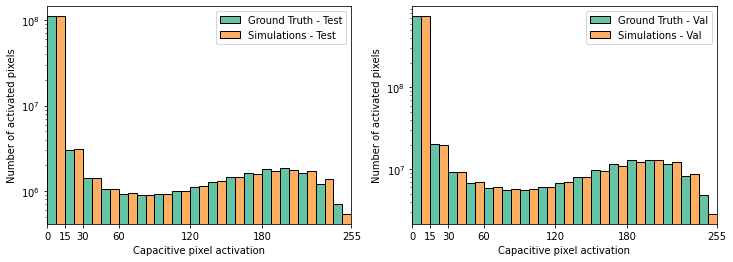

In [59]:
%%time
fig, ax = plt.subplots(1, 2, figsize = (12,4))

hist_blob = np.histogram(np.stack(df[df.Datatype == 'test'].Blob.values).reshape(-1), range = (0,255), bins = 17)
hist_sim = np.histogram(np.stack(df[df.Datatype == 'test'].Simulation.values).reshape(-1), range = (0,255), bins = 17)
#ax[0].bar(hist_train[1][:-1]+5,values_train, width = 10, ec= 'black')
ax[0].bar(hist_blob[1][:-1]+3.75,hist_blob[0], width = 7.5, ec= 'black', color = '#66c2a5', alpha = 1,label = 'Ground Truth - Test')
ax[0].bar(hist_sim[1][:-1]+11.25,hist_sim[0], width = 7.5, ec= 'black', color = '#fdae61', alpha = 1, label = 'Simulations - Test')
ax[0].set_ylabel('Number of activated pixels')
ax[0].set_xlabel('Capacitive pixel activation')
ax[0].set_yscale('log')
ax[0].set_xticks(list(range(0,250,50)) + [255])
ax[0].set_xticks([0,15, 30, 60, 120, 180, 255])
ax[0].set_xlim(0,255)
ax[0].legend()

hist_blob = np.histogram(np.stack(df_val.Blob.values).reshape(-1), range = (0,255), bins = 17)
hist_sim = np.histogram(np.stack(df_val.Simulation.values).reshape(-1), range = (0,255), bins = 17)

#ax[0].bar(hist_train[1][:-1]+5,values_train, width = 10, ec= 'black')
ax[1].bar(hist_blob[1][:-1]+3.75,hist_blob[0], width = 7.5, ec= 'black', color = '#66c2a5', alpha = 1,label = 'Ground Truth - Val')
ax[1].bar(hist_sim[1][:-1]+11.25,hist_sim[0], width =  7.5, ec= 'black', color = '#fdae61', alpha = 1, label = 'Simulations - Val')
ax[1].set_ylabel('Number of activated pixels')
ax[1].set_xlabel('Capacitive pixel activation')
ax[1].set_yscale('log')
ax[1].set_xticks(list(range(0,250,50)) + [255])
ax[1].set_xticks([0,15, 30, 60, 120, 180, 255])
ax[1].set_xlim(0,255)
ax[1].legend()

CPU times: user 13.4 s, sys: 2.03 s, total: 15.4 s
Wall time: 15.4 s


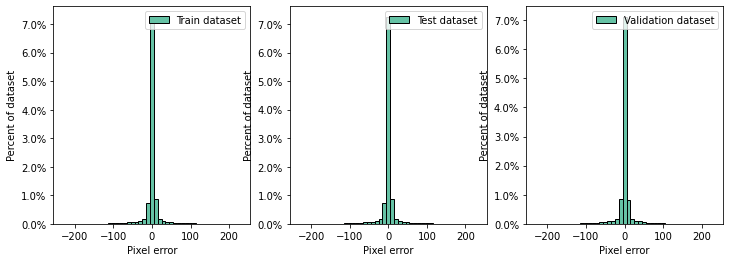

In [52]:
%%time
fig, ax = plt.subplots(1, 3, figsize = (12,4))

ax[0].hist(np.stack(df[df.Datatype == 'train'].Diff.values).reshape(-1), range = (-255,255), density=True, bins = 51, ec= 'black', color = '#66c2a5', label = 'Train dataset') 
ax[0].set_ylabel('Percent of dataset')
ax[0].set_xlabel('Pixel error')
ax[0].set_xlim(-255,255)
ax[0].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
#ax[0].set_yscale('log')
ax[0].legend()

ax[1].hist(np.stack(df[df.Datatype == 'test'].Diff.values).reshape(-1), range = (-255,255), density=True, bins = 51, ec= 'black', color = '#66c2a5', label = 'Test dataset')
ax[1].set_ylabel('Percent of dataset')
ax[1].set_xlabel('Pixel error')
ax[1].set_xlim(-255,255)
ax[1].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
#ax[1].set_yscale('log')
ax[1].legend()

ax[2].hist(np.stack(df_val.Diff.values).reshape(-1), range = (-255,255), density=True, bins = 51, ec= 'black', color = '#66c2a5', label = 'Validation dataset')
ax[2].set_ylabel('Percent of dataset')
ax[2].set_xlabel('Pixel error')
ax[2].set_xlim(-255,255)
ax[2].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
#ax[2].set_yscale('log')
ax[2].legend()

CPU times: user 1.06 s, sys: 116 ms, total: 1.18 s
Wall time: 1.18 s


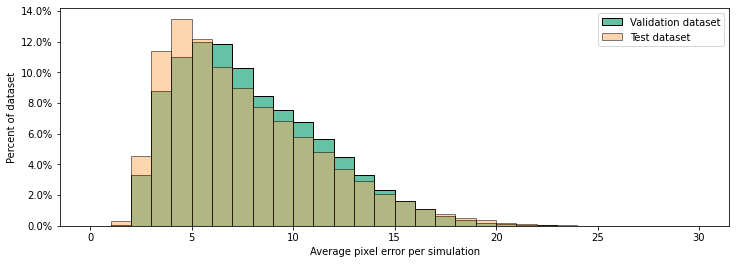

In [63]:
%%time
fig, ax = plt.subplots(figsize = (12,4))

ax.hist(np.stack(df_val.AveragePixelError.values).reshape(-1), range = (0,30), density=True, bins = 30, ec= 'black', color = '#66c2a5', label = 'Validation dataset')
ax.hist(np.stack(df[df.Datatype == 'test'].AveragePixelError.values).reshape(-1), range = (0,30), density=True, bins =30, alpha = .5, ec= 'black', color = '#fdae61', label = 'Test dataset')
ax.set_ylabel('Percent of dataset')
ax.set_xlabel('Average pixel error per simulation')
#ax.set_xlim(0,25)
#ax.set_yticks(np.arange(0,15,2))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
ax.legend()
#fig.savefig('./out/paper-images/simulator_average_error_large.pdf', bbox_inches = 'tight')

In [51]:
px_train = np.abs(np.stack(df[df.Datatype == 'train'].Diff.values).reshape(-1))
px_val = np.abs(np.stack(df[df.Datatype == 'test'].Diff.values).reshape(-1))
px_test = np.abs(np.stack(df_val.Diff.values).reshape(-1))

In [53]:
print(f"""Pixel error
Train Mean = {px_train.mean():.3f} (SD = {px_train.std():.3f})
Val Mean = {px_val.mean():.3f} (SD = {px_val.std():.3f})
Test Mean = {px_test.mean():.3f} (SD = {px_test.std():.3f})
""")

Pixel error
Train Mean = 7.587 (SD = 18.043)
Val Mean = 7.602 (SD = 18.072)
Test Mean = 7.929 (SD = 18.354)



In [54]:
print(f"""Pixel error
Train Mean = {px_train.mean():.3f} (SD = {px_train.std():.3f})
Val Mean = {px_val.mean():.3f} (SD = {px_val.std():.3f})
Test Mean = {px_test.mean():.3f} (SD = {px_test.std():.3f})
""")

Pixel error
Train Mean = 7.587 (SD = 18.043)
Val Mean = 7.602 (SD = 18.072)
Test Mean = 7.929 (SD = 18.354)



# Visual Inspection of the Simulated Capacitive Images

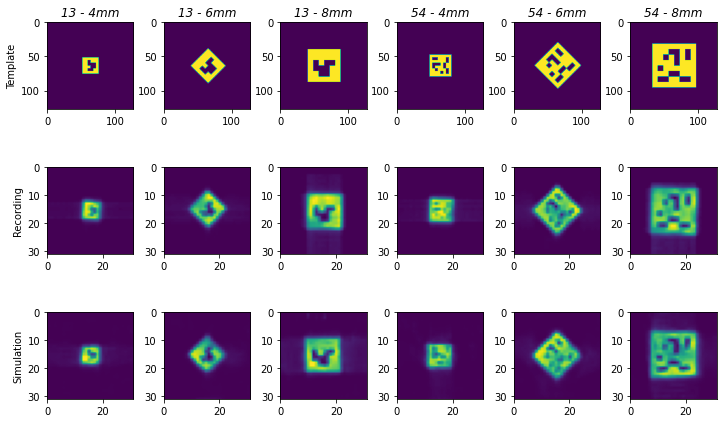

In [34]:
fig, ax = plt.subplots(3,6, figsize = (12,8))
axs = ax.flatten()
plotNum = 0
for i, (markerType, ID) in enumerate([("16h5", 13),("36h11", 54)]):
    angle = 0

    for j, size in enumerate(df_val.Size.unique()):
        e = df_val[(df_val.MarkerType == markerType)&(df_val.Id == ID)&(df_val.Size == size)&(df_val.Angle == angle)].iloc[0]
        template = e.Template
        blob = e.Blob
        simulation = e.Simulation.reshape(32,32)

        axs[plotNum].imshow(template)
        axs[plotNum].set_ylim(127, 0)
        axs[plotNum].set_xlim(0,127)
        axs[plotNum].set_title(f'{ID} - {size}mm', fontstyle = 'italic')

        axs[plotNum + 6].imshow(blob, vmin=0, vmax=255)
        axs[plotNum + 6].set_ylim(31, 0)
        axs[plotNum + 6].set_xlim(0,31)

        axs[plotNum + 12].imshow(simulation, vmin=0, vmax=255)
        axs[plotNum + 12].set_ylim(31, 0)
        axs[plotNum + 12].set_xlim(0,31)
        plotNum += 1
        angle += 45

axs[0].set_ylabel('Template')
axs[6].set_ylabel('Recording')
axs[12].set_ylabel('Simulation')
#fig.tight_layout() 
plt.subplots_adjust(wspace = .35, hspace = 0.)
plt.show()

# Visual Inspection of the Impact of Shift on the Simulation

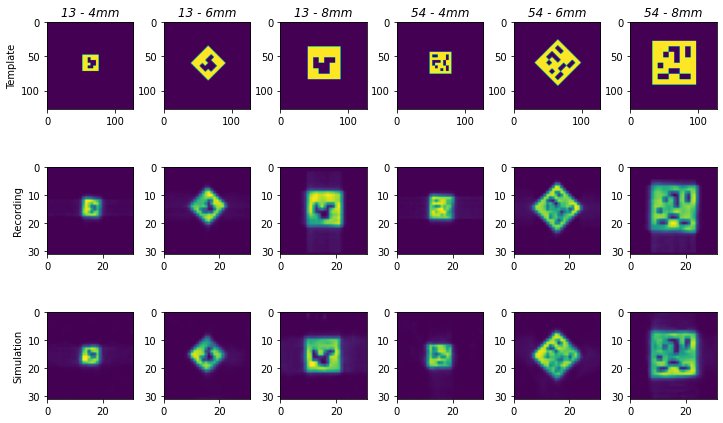

#####################################


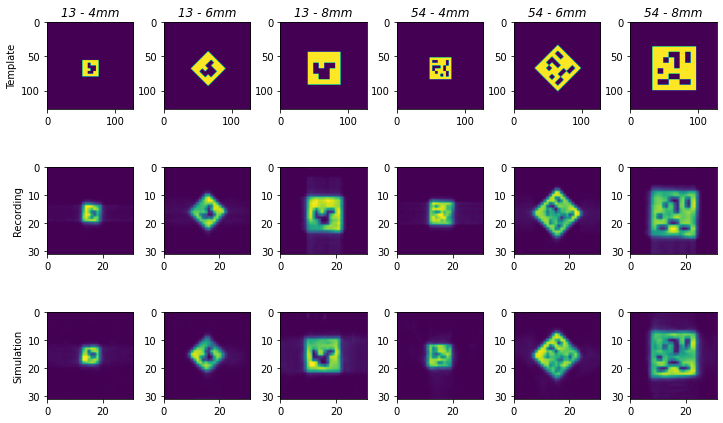

#####################################


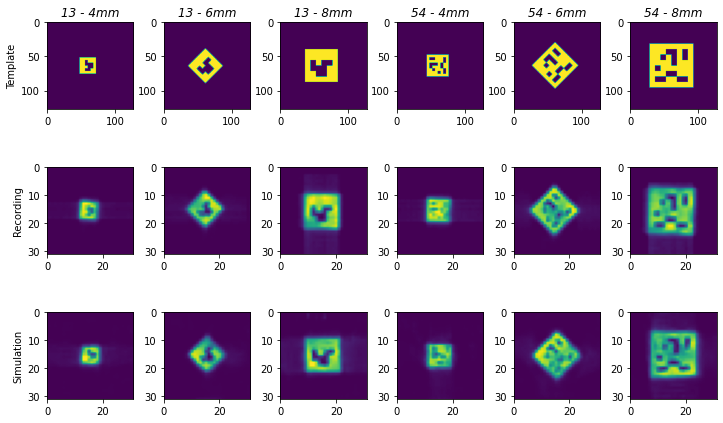

#####################################


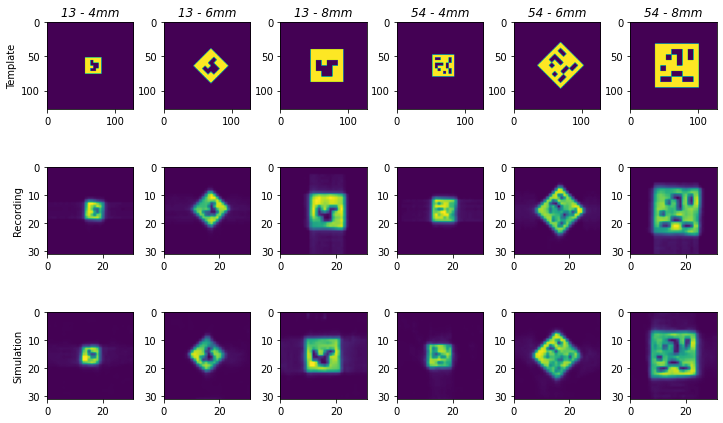

#####################################


In [33]:
for shift_axis in [0, 1]:
    for shift_amount in [-1,1]:
        fig, ax = plt.subplots(3,6, figsize = (12,8))
        axs = ax.flatten()
        plotNum = 0
        for i, (markerType, ID) in enumerate([("16h5", 13),("36h11", 54)]):
            angle = 0

            for j, size in enumerate(df_val.Size.unique()):
                e = df_val[(df_val.MarkerType == markerType)&(df_val.Id == ID)&(df_val.Size == size)&(df_val.Angle == angle)].iloc[0]
                template = e.Template
                template = np.roll(template, shift_amount*4, axis = shift_axis)
                blob = e.Blob
                blob = np.roll(blob, shift_amount, axis = shift_axis)
                simulation = e.Simulation.reshape(32,32)

                axs[plotNum].imshow(template)
                axs[plotNum].set_ylim(127, 0)
                axs[plotNum].set_xlim(0,127)
                axs[plotNum].set_title(f'{ID} - {size}mm', fontstyle = 'italic')

                axs[plotNum + 6].imshow(blob, vmin=0, vmax=255)
                axs[plotNum + 6].set_ylim(31, 0)
                axs[plotNum + 6].set_xlim(0,31)

                axs[plotNum + 12].imshow(simulation, vmin=0, vmax=255)
                axs[plotNum + 12].set_ylim(31, 0)
                axs[plotNum + 12].set_xlim(0,31)
                plotNum += 1
                angle += 45

        axs[0].set_ylabel('Template')
        axs[6].set_ylabel('Recording')
        axs[12].set_ylabel('Simulation')
        #fig.tight_layout() 
        plt.subplots_adjust(wspace = .35, hspace = 0.)
        plt.show()
        print('#####################################')